# Homework 4 Part 2

---

In [1]:
# Load libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.metrics import rand_score
from numpy.random import permutation
from sklearn.cluster import KMeans
from numpy.linalg import norm
import scipy.stats as stats
import random

In [2]:
def pcm(X, K, m, metric, alpha, beta, centers_init):
    #X is the input data, Nxd
    #K is the number of clusters
    #m is the fuzzifier
    
    #Parameters
    MaxIter = 10_000
    StopThresh = 1e-5
    
    #Initialize Cluster Centers by drawing Randomly from Data (can use other methods for initialization...)
    N, d = np.shape(X) # number of data points, dimensionality
    
    # Compute squared of distance to every centroid
    D = cdist(X, centers_init, metric = metric)**2
    centers = centers_init
    
    # Initialization for weight value for each cluster
    eta = np.ones(K)
    
    # Memberships
    U = np.zeros((N,K))
    for i in range(N):
        for j in range(K):
            U[i,j] = 1/(1+ ((D[i,j]/eta[j])**(1/(m-1))))
    
    diff = np.inf
    it = 0
    while diff > StopThresh and it < MaxIter:

        # Update cluster centers
        for i in range(K):
            num = np.zeros(d)
            den = np.zeros(d)
            for j in range(N):
                num = num + U[j,i]**m * X[j,:]
                den = den + U[j,i]**m
            centers[i,:] = np.squeeze(num/den)
        
        # Update distance to centers
        D = cdist(X, centers, metric='euclidean')**2
        
        # Update U
        UPrev = U
        for i in range(N):
            for j in range(K):
                U[i,j] = 1/(1+ ((D[i,j]/eta[j])**(1/(m-1))))
                
        # Update eta (option 1)
        for j in range(K):
            num = 0
            den = 0
            for i in range(N):
                num = num + U[i,j]**m*D[i,j]
                den = den + U[i,j]**m
            eta[j] = beta*num/den
            
#         # Update eta (option 2)
#         for j in range(K):
#             dp = 0
#             ccount = 0
#             for i in range(N):
#                 if U[i,j] >= alpha:
#                     dp = dp + D[i,j]
#                     ccount = ccount + 1
#             if ccount != 0:
#                 eta[j] = dp/ccount
#             else:
#                 eta[j] = 0

        # Update diff & iteration count for stopping criteria
        diff = norm(UPrev - U)# membership
        it+=1

    return centers, U, eta

---

# Problem 1 (15 points)

**Write a Python function to implement Fuzzy C-Means (FCM).**

In [3]:
def fcm(X, K, m, metric, centers_init):
    #X is the input data (array N-by-d)
    #K is the number of clusters (int)
    #m is the fuzzifier (int)
    #metric is the distance metric (string)
    #center_init is initialization for cluster centroids (array, K-by-D)
    
    #Parameters
    MaxIter = 10_000
    StopThresh = 1e-5
    
    #Initialize Cluster Centers by drawing Randomly from Data (can use other methods for initialization...)
    N, d = np.shape(X) # number of data points, dimensionality
    
    # Pairwise distances squared (N x K)
    D = cdist(X, centers_init, metric = metric)**2
    centers = centers_init
    
    # Membership
    U = np.zeros((N,K))
    for i in range(N):
        for j in range(K):
            U[i,j] = 1/sum((D[i,j]/D[i,:])**(1/(m-1)))
    
    diff = np.inf
    it = 0
    while diff > StopThresh and it < MaxIter:

        # Update cluster centers
        for j in range(K):
            num = np.zeros(d)
            den = np.zeros(d)
            for i in range(N):
                num = num + U[i,j]**m * X[i,:]
                den = den + U[i,j]**m
            centers[j,:] = np.squeeze(num/den)
        
        # Update distance to centers
        D = cdist(X, centers, metric=metric)**2
        
        # Update U
        UPrev = U
        for i in range(N):
            for j in range(K):
                U[i,j] = 1/sum((D[i,j]/D[i,:])**(1/(m-1)))
            
        # Update diff & iteration count for stopping criteria
        diff = norm(UPrev - U)
        it+=1

    return centers, U

In [4]:
def clusters_in_test(X, U, centers):
    '''Measures which centroid data points are closest to (centroid-based clustering).
    Select label corresponding to closest cluster centroid.'''
    
    labels = np.argmin(cdist(X,centers),axis=1)
    
    memberships = np.max(U, axis=1)
    
    return labels, memberships

# Problem 2 (30 points)

**Use the [Digits Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) to answer the following questions.**

**Start by partitioning the data into training (80%) and test (20%) sets at random (fix random seed for reproducibility). Use the training set train the clustering algorithms and the test set to evaluate performances.**

**Complete the following tasks:**

1. **Implement the following clustering algorithms: [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [Gaussian Mixture Model (GMM)](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), Fuzzy C-Means (FCM) with $m=2$, and Possibilistic C-Means (PCM) with $m=2$ with the same cluster centroids initializations and $K=10$ for all algorithms.**

2. **For each cluster: (1) plot the cluster centroids, and (2) samples assigned to respective cluster in decreasing order of membership value. Discuss observations.**

3. **Which model has sharper or more diffuse cluster boundaries? Which model assigns more or less importance to points that are near the border of the two clusters? Which one requires more or less preprocessing or hyperparameter tuning?**

4. **Measure performance in test set using the [rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html).**

In [5]:
from sklearn.datasets import load_digits

digits = load_digits(return_X_y=False)
# print(digits.DESCR)

X = digits.data/255.0
t = digits.target

X.shape, t.shape

((1797, 64), (1797,))

In [6]:
# Partition the data
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2,
                                                   stratify=t,
                                                   random_state=0)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [7]:
# Hyperparameters
D = X_train.shape[1] # dimensionality
K = 10 # number of clusters
metric = 'euclidean' # distance metric
m = 2 # fuzzifier (hyperparameter in fcm and pcm)
alpha  = 0.7 # hyperaparameter in pcm
beta   = 1 # hyperparameter in pcm

# Cluster initializations (K-by-D)
# Randomly generate data from Normal distribution
seed = 7
random.seed(seed)
rp = permutation(X_train.shape[0]) #random permutation of numbers 1:N
centers_init = X_train[rp[:K],:] #select first K data points sorted according to rp
centers_init += stats.norm.rvs(size=(K,D))*0.0001 # added random noise to avoid dividing by zero in fcm/pcm

## K-Means

K-Means is a centroid-based clustering algorithm with crisp (or binary) membership values, $u_{ij}=\{0,1\}\; \forall i=1,2,\dots,N \; \text{ and } \; j=1,2,\dots, K$, and $\sum_{j=1}^K u_{ij} = 1$.

* The membership values are crisp/sharp/binary, for all points assigned to the cluster, even if samples are at cluster boundaries.

* K-Means is very sensitive to outliers, and it is not able to eliminate them.

* Standard K-Means (with Euclidean distance) is computationally cheap, it only requires defining the number of clusters to learn.

For points assigned to a particular cluster, I will display them based on proximity to its cluster centroid.

In [8]:
# K-Means Training

kmeans = KMeans(n_clusters=K, init=centers_init)
kmeans.fit(X_train)

/Users/catiaspsilva/miniconda3/envs/fml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


KMeans(init=array([[ 1.27923448e-04,  5.83290431e-05,  1.96803274e-02,
         5.89412072e-02,  5.47292368e-02,  1.17185709e-02,
        -1.10219374e-04, -1.07443443e-04,  6.74623723e-05,
         5.96933386e-05,  4.70771660e-02,  2.74461497e-02,
         7.77779913e-03,  4.70698510e-02, -1.26699606e-04,
         1.58134288e-04,  5.69466329e-05, -5.93898852e-06,
         6.25900853e-02,  1.17193200e-02, -7.26353486e-05,
         4.69947254...
         4.29312094e-02,  3.13449088e-02,  7.83534336e-03,
         1.16604848e-02,  5.09626631e-02, -1.97177427e-04,
        -1.47069340e-05,  3.76299195e-05,  2.73931435e-02,
         4.30061442e-02,  1.94150886e-02,  4.70240996e-02,
         4.29840749e-02, -8.47352617e-05, -1.40788883e-04,
        -5.25003911e-05,  3.98327760e-03,  4.31240028e-02,
         4.70843380e-02,  1.57970599e-02, -1.65433088e-05,
         3.60599939e-05]]),
       n_clusters=10)

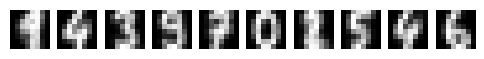

In [9]:
# Displaying centroids
centers_kmeans = kmeans.cluster_centers_

plt.figure(figsize=(6,2))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow(centers_kmeans[i,:].reshape(8,8), cmap='gray')
    plt.axis('off');

**Observations:**

* Since clustering is unsupervised, it is not expected that we will converge to 10 unit cluster centroids.

* It appears that 2 cluster centroids are visually close to digit 1/9. This can be better observed in the next plots.

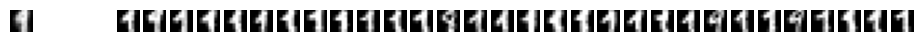

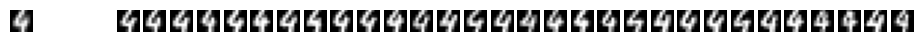

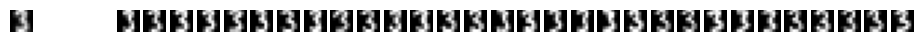

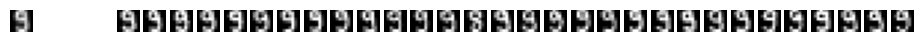

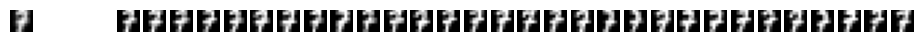

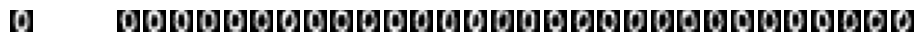

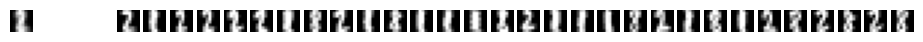

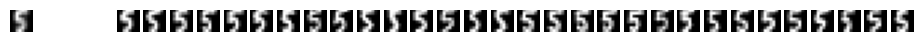

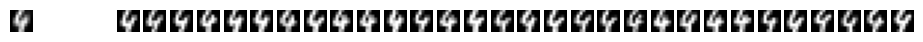

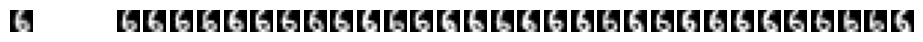

In [10]:
# Displaying closest 30 samples
y_train_kmeans = kmeans.predict(X_train)

for i in range(K):
    plt.figure(figsize=(12,14))
    idx = np.where(y_train_kmeans==i)[0] # identifying samples assigned to cluster i
    N = min(len(idx), 30)
    distances = norm(X_train[idx,:]-centers_kmeans[i,:], axis=1) # Euclidean distance to cluster centroid
    id_to_plot = idx[np.argsort(distances)][:N] # identify closest 30 samples to cluster centroid
    plt.subplot(i+1,35,1); plt.imshow(centers_kmeans[i,:].reshape(8,8), cmap='gray'); plt.axis('off')
    for j in range(30):
        plt.subplot(i+1,35,j+5)
        plt.imshow(X_train[id_to_plot[j],:].reshape(8,8), cmap='gray'); plt.axis('off');

Clustering performance can be measured with external criteria measures such as rand score. It measures how many samples are assigned to the same cluster as an external set of labels. 

* The rand score values range is [0,1]. The closer to 1, the better the clustering results.

In [11]:
# K-Means Predict and Rand Score
y_test_kmeans = kmeans.predict(X_test)
print('K-MEANS: rand score = ', rand_score(t_test, y_test_kmeans))

K-MEANS: rand score =  0.9214175177963478


## Gaussian Mixture Models (GMMs)

GMM is a distribution-based clustering algorithm with soft membership values, $u_{ij}=[0,1]\; \forall i=1,2,\dots,N \; \text{ and } \; j=1,2,\dots, K$, and $\sum_{j=1}^K u_{ij} = 1$.

* The membership values are probabilistic. Points at the cluster edges will have lower membership/probability value.

* GMM is not as sensitive to outliers as K-Means, as it learns probabilistic models that best fit the data.

* GMM requires the learning of all cluster means and as well cluster covariance matrices.

For points assigned to a particular cluster, I will display them based in decreasing order of their membership values.

In [12]:
# GMM

gmm = GaussianMixture(n_components=K, covariance_type='full', means_init=centers_init, max_iter=10_000, tol=1E-10)
gmm.fit(X_train)

GaussianMixture(max_iter=10000,
                means_init=array([[ 1.27923448e-04,  5.83290431e-05,  1.96803274e-02,
         5.89412072e-02,  5.47292368e-02,  1.17185709e-02,
        -1.10219374e-04, -1.07443443e-04,  6.74623723e-05,
         5.96933386e-05,  4.70771660e-02,  2.74461497e-02,
         7.77779913e-03,  4.70698510e-02, -1.26699606e-04,
         1.58134288e-04,  5.69466329e-05, -5.93898852e-06,
         6.25900853e-02,  1.17193200e...
         4.29312094e-02,  3.13449088e-02,  7.83534336e-03,
         1.16604848e-02,  5.09626631e-02, -1.97177427e-04,
        -1.47069340e-05,  3.76299195e-05,  2.73931435e-02,
         4.30061442e-02,  1.94150886e-02,  4.70240996e-02,
         4.29840749e-02, -8.47352617e-05, -1.40788883e-04,
        -5.25003911e-05,  3.98327760e-03,  4.31240028e-02,
         4.70843380e-02,  1.57970599e-02, -1.65433088e-05,
         3.60599939e-05]]),
                n_components=10, tol=1e-10)

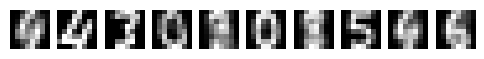

In [13]:
# Displaying centroids
centers_gmm = gmm.means_

plt.figure(figsize=(6,2))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow(centers_gmm[i,:].reshape(8,8), cmap='gray')
    plt.axis('off');

**Observations:**

* Similar to K-Means, GMM is unsupervised thus it is not expected that we will converge to 10 unit cluster centroids.

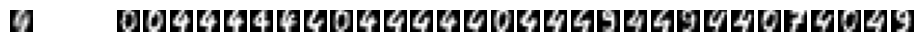

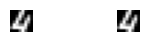

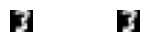

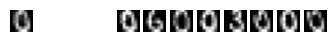

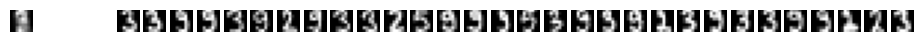

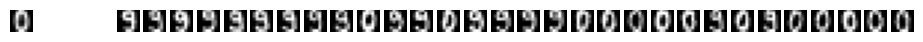

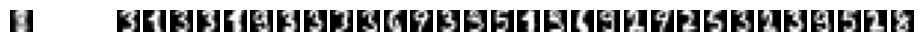

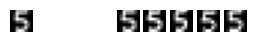

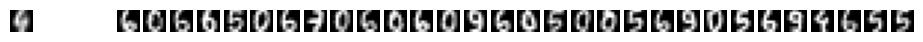

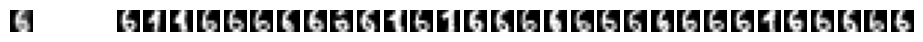

In [14]:
# Displaying closest samples
y_train_gmm = gmm.predict(X_train)
prob_train_gmm = np.max(gmm.predict_proba(X_train), axis=1)

for i in range(K):
    plt.figure(figsize=(12,8))
    idx = np.where(y_train_gmm==i)[0] # identifying samples assigned to cluster i
    N = min(len(idx), 30) 
    memberships = prob_train_gmm[idx] # membership values in cluster centroid
    id_to_plot = idx[np.argsort(memberships)][:N] # identify N samples with highest membership values
    plt.subplot(i+1,35,1); plt.imshow(centers_gmm[i,:].reshape(8,8), cmap='gray'); plt.axis('off')
    for j in range(N):
        plt.subplot(i+1,35,j+5)
        plt.imshow(X_train[id_to_plot[j],:].reshape(8,8), cmap='gray'); plt.axis('off');

In [15]:
# GMM Predict and Rand Score
y_test_gmm = gmm.predict(X_test)
print('GMM: rand score = ', rand_score(t_test, y_test_gmm))

GMM: rand score =  0.7745125348189416


## Fuzzy C-Means (FCM)

FCM is a centroid-based clustering algorithm with soft membership values, $u_{ij}=[0,1]\; \forall i=1,2,\dots,N \; \text{ and } \; j=1,2,\dots, K$, and $\sum_{j=1}^K u_{ij} = 1$.

* The membership values are probabilistic. Points at the cluster edges will have lower membership/probability value.

* FCM is still sensitive to outliers. Outlier points will be assigned to one cluster with relatively large membership value.

* FCM requires an extra hyperparameter, the fuzzifier $m$.

For points assigned to a particular cluster, I will display them based in decreasing order of their membership values.

In [16]:
# FCM

centers_fcm, U_fcm = fcm(X_train, K, m, metric, centers_init)

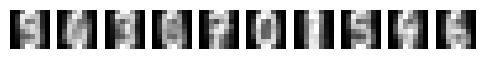

In [17]:
# Displaying centroids

plt.figure(figsize=(6,2))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow(centers_fcm[i,:].reshape(8,8), cmap='gray')
    plt.axis('off');

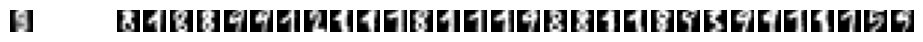

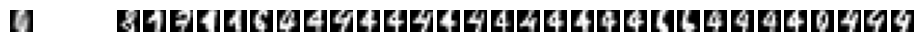

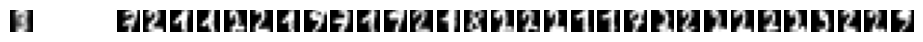

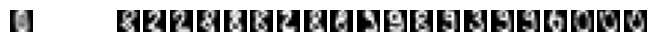

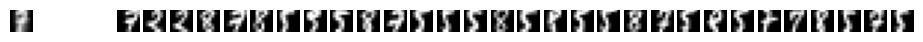

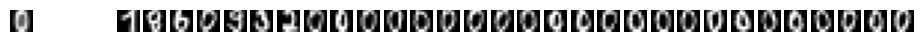

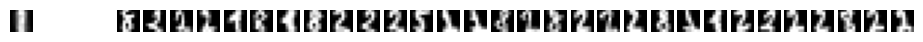

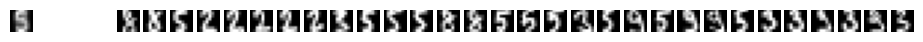

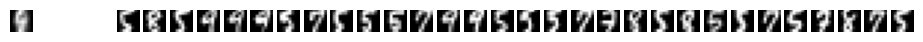

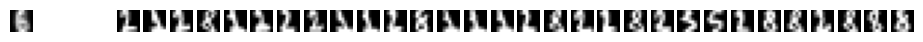

In [18]:
# Displaying closest samples
y_train_fcm, prob_train_fcm = clusters_in_test(X_train, U_fcm, centers_fcm)

for i in range(K):
    plt.figure(figsize=(12,8))
    idx = np.where(y_train_fcm==i)[0] # identifying samples assigned to cluster i
    N = min(len(idx), 30) 
    memberships = prob_train_fcm[idx] # membership values in cluster centroid
    id_to_plot = idx[np.argsort(memberships)][:N] # identify N samples with highest membership values
    plt.subplot(i+1,35,1); plt.imshow(centers_fcm[i,:].reshape(8,8), cmap='gray'); plt.axis('off')
    for j in range(N):
        plt.subplot(i+1,35,j+5)
        plt.imshow(X_train[id_to_plot[j],:].reshape(8,8), cmap='gray'); plt.axis('off');

In [19]:
# FCM Predict and Rand Score
y_test_fcm, _ = clusters_in_test(X_test, U_fcm, centers_fcm)
print('FCM: rand score = ', rand_score(t_test, y_test_fcm))

FCM: rand score =  0.8873259052924791


## Possibilistic C-Means (PCM)

FCM is a centroid-based clustering algorithm with soft membership values, $u_{ij}=[0,1]\; \forall i=1,2,\dots,N \; \text{ and } \; j=1,2,\dots, K$. In PCM, the constraint $\sum_{j=1}^K u_{ij}=1$ is lifted. Thus, the memberships are viewed as possibilistic rather than probabilistic.

* The membership values are possibilistic. Points at the cluster edges will have lower membership/probability value for all clusters.

* FCM is able to assign a low membership value for outliers in all clusters.

* FCM requires an extra hyperparameter $\beta$ and learning an extra parameter $\eta_j, j=1,2,\dots, K$.

For points assigned to a particular cluster, I will display them based in decreasing order of their membership values.

In [20]:
# PCM

centers_pcm, U_pcm, _ = pcm(X_train, K, m, metric, alpha, beta, centers_init)

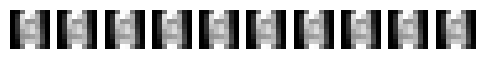

In [21]:
# Displaying centroids

plt.figure(figsize=(6,2))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow(centers_pcm[i,:].reshape(8,8), cmap='gray')
    plt.axis('off');

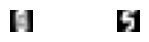

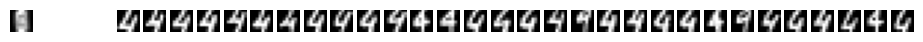

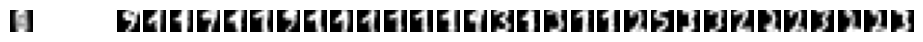

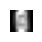

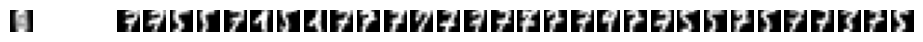

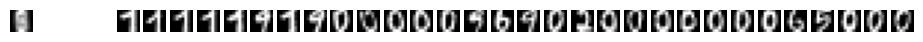

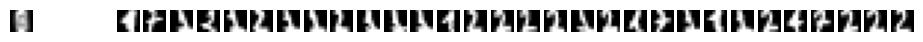

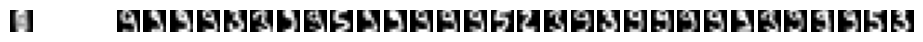

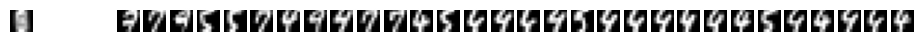

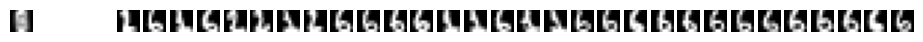

In [22]:
# Displaying closest samples
y_train_pcm, prob_train_pcm = clusters_in_test(X_train, U_pcm, centers_pcm)

for i in range(K):
    plt.figure(figsize=(12,8))
    idx = np.where(y_train_pcm==i)[0] # identifying samples assigned to cluster i
    N = min(len(idx), 30) 
    memberships = prob_train_pcm[idx] # membership values in cluster centroid
    id_to_plot = idx[np.argsort(memberships)][:N] # identify N samples with highest membership values
    plt.subplot(i+1,35,1); plt.imshow(centers_pcm[i,:].reshape(8,8), cmap='gray'); plt.axis('off')
    for j in range(N):
        plt.subplot(i+1,35,j+5)
        plt.imshow(X_train[id_to_plot[j],:].reshape(8,8), cmap='gray'); plt.axis('off');

In [23]:
# PCM Predict and Rand Score
y_test_pcm, _ = clusters_in_test(X_test, U_pcm, centers_pcm)
print('PCM: rand score = ', rand_score(t_test, y_test_pcm))

PCM: rand score =  0.866976168368926


---

# On-Time (5 points)

Submit your assignment before the deadline.

---